In [4]:
import numpy as np
import pandas as pd
import json
import collections
from collections import defaultdict 
from functools import partial
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


In [5]:
# multi_visit_mimic_dir = '/home/am8520/GP/ehr-data/mimic3-multi-visit'
multi_visit_mimic_dir = '/home/asem/GP/ehr-data/mimic3-multi-visit'

PATIENTS = pd.read_csv(f'{multi_visit_mimic_dir}/PATIENTS.csv.gz')
ADMISSIONS = pd.read_csv(f'{multi_visit_mimic_dir}/ADMISSIONS.csv.gz')
DIAGNOSES_ICD = pd.read_csv(f'{multi_visit_mimic_dir}/DIAGNOSES_ICD.csv.gz', dtype = {'ICD9_CODE': str})
PROCEDURES_ICD = pd.read_csv(f'{multi_visit_mimic_dir}/PROCEDURES_ICD.csv.gz', dtype = {'ICD9_CODE': str})

In [3]:
LABEVENTS = pd.read_csv(f'{multi_visit_mimic_dir}/LABEVENTS_Q5_UNITS_FIXED.csv.gz')
CHARTEVENTS = pd.read_csv(f'{multi_visit_mimic_dir}/CHARTEVENTS_Q5.csv.gz')

KeyboardInterrupt: 

In [6]:
PATIENTS

,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,234,249,F,2075-03-13 00:00:00,NaN,NaN,NaN,0
1,237,252,M,2078-03-06 00:00:00,NaN,NaN,NaN,0
2,240,256,M,2086-07-31 00:00:00,NaN,NaN,NaN,0
3,628,665,M,2052-05-20 00:00:00,2120-02-04 00:00:00,2120-02-04 00:00:00,NaN,1
4,637,674,F,2113-12-14 00:00:00,2195-02-17 00:00:00,2195-02-17 00:00:00,2195-02-17 00:00:00,1
...,...,...,...,...,...,...,...,...
7532,31813,43982,F,2065-04-17 00:00:00,NaN,NaN,NaN,0
7533,31816,43991,M,2069-01-27 00:00:00,NaN,NaN,NaN,0
7534,31831,44061,M,2073-09-29 00:00:00,NaN,NaN,NaN,0
7535,31832,44064,M,2115-11-18 00:00:00,NaN,NaN,NaN,0


In [7]:
ADMISSIONS

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
1,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
2,33,34,115799,2186-07-18 16:46:00,2186-07-20 16:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,CHEST PAIN\CATH,0,1
3,34,34,144319,2191-02-23 05:23:00,2191-02-25 20:20:00,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,2191-02-23 04:23:00,2191-02-23 07:25:00,BRADYCARDIA,0,1
4,36,36,182104,2131-04-30 07:15:00,2131-05-08 14:00:00,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME HEALTH CARE,Medicare,ENGL,NOT SPECIFIED,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19988,58585,98761,184477,2186-01-16 10:30:00,2186-01-16 16:30:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME,Private,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,GASTROPARESIS\PLACEMENT OF G-TUBE **REMOTE WES...,0,0
19989,58586,98761,182540,2186-02-08 12:30:00,2186-02-08 20:21:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,SHORT GUT SYNDROME/SDA,0,0
19990,58587,98761,175884,2189-07-10 18:08:00,2189-07-17 14:57:00,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,2189-07-10 14:46:00,2189-07-10 20:28:00,DEHYDRATION,0,1
19991,58597,98813,170407,2128-11-11 02:29:00,2128-12-22 13:11:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Private,ENGL,CATHOLIC,MARRIED,WHITE,2128-11-10 23:48:00,2128-11-11 03:16:00,S/P FALL,0,0


In [8]:
admit = pd.to_datetime(ADMISSIONS['ADMITTIME'], infer_datetime_format=True).dt.normalize() 
disch = pd.to_datetime(ADMISSIONS['DISCHTIME'], infer_datetime_format=True).dt.normalize()
ADMISSIONS['DAYS'] = (disch - admit).dt.days
ADMISSIONS

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,DAYS
0,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1,5
1,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1,7
2,33,34,115799,2186-07-18 16:46:00,2186-07-20 16:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,CHEST PAIN\CATH,0,1,2
3,34,34,144319,2191-02-23 05:23:00,2191-02-25 20:20:00,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,2191-02-23 04:23:00,2191-02-23 07:25:00,BRADYCARDIA,0,1,2
4,36,36,182104,2131-04-30 07:15:00,2131-05-08 14:00:00,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME HEALTH CARE,Medicare,ENGL,NOT SPECIFIED,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19988,58585,98761,184477,2186-01-16 10:30:00,2186-01-16 16:30:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME,Private,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,GASTROPARESIS\PLACEMENT OF G-TUBE **REMOTE WES...,0,0,0
19989,58586,98761,182540,2186-02-08 12:30:00,2186-02-08 20:21:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,SHORT GUT SYNDROME/SDA,0,0,0
19990,58587,98761,175884,2189-07-10 18:08:00,2189-07-17 14:57:00,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,2189-07-10 14:46:00,2189-07-10 20:28:00,DEHYDRATION,0,1,7
19991,58597,98813,170407,2128-11-11 02:29:00,2128-12-22 13:11:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Private,ENGL,CATHOLIC,MARRIED,WHITE,2128-11-10 23:48:00,2128-11-11 03:16:00,S/P FALL,0,0,41


In [9]:
longest_admission = {}
for subject_id, subject_df in ADMISSIONS.groupby('SUBJECT_ID'):
    longest_admission[subject_id] = subject_df.DAYS.max()
    
ADMISSIONS['MAX_DAYS'] = ADMISSIONS.SUBJECT_ID.map(longest_admission)
subjects = list(set(ADMISSIONS.SUBJECT_ID))
longest_admission_df = pd.DataFrame({'SUBJECT_ID': subjects,
                                    'LONGEST_ADMISSION': map(longest_admission.get, subjects)})

<AxesSubplot:xlabel='DAYS', ylabel='Count'>

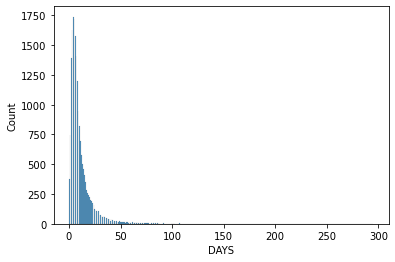

In [10]:
sns.histplot(data=ADMISSIONS, x="DAYS")

In [11]:
np.mean(ADMISSIONS.MAX_DAYS <= 14)

0.5478917621167408

<AxesSubplot:xlabel='LONGEST_ADMISSION', ylabel='Count'>

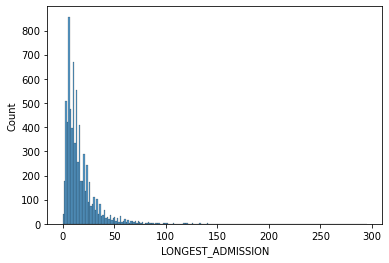

In [12]:
sns.histplot(data=longest_admission_df, x="LONGEST_ADMISSION")

In [13]:
np.mean(longest_admission_df.LONGEST_ADMISSION <= 14)

0.5882977311927823

In [14]:
len(subjects)

7537

In [15]:
np.mean(longest_admission_df.LONGEST_ADMISSION <= 14) * len(subjects)

4434.0

In [16]:
subjects_2wks = set(longest_admission_df[longest_admission_df.LONGEST_ADMISSION <= 14].SUBJECT_ID)

In [17]:
len(subjects_2wks)

4434

In [18]:
PATIENTS_2WKS = PATIENTS[PATIENTS.SUBJECT_ID.isin(subjects_2wks)].reset_index(drop=True)
ADMISSIONS_2WKS = ADMISSIONS[ADMISSIONS.SUBJECT_ID.isin(subjects_2wks)].reset_index(drop=True)
DIAGNOSES_ICD_2WKS = DIAGNOSES_ICD[DIAGNOSES_ICD.SUBJECT_ID.isin(subjects_2wks)].reset_index(drop=True)
PROCEDURES_ICD_2WKS = PROCEDURES_ICD[PROCEDURES_ICD.SUBJECT_ID.isin(subjects_2wks)].reset_index(drop=True)

In [19]:
ADMISSIONS_2WKS['DAYS'].describe()

count    10954.000000
mean         5.926146
std          3.489328
min          0.000000
25%          3.000000
50%          5.000000
75%          8.000000
max         14.000000
Name: DAYS, dtype: float64

## Intervals between successive admissions

In [21]:
ADMISSIONS_2WKS.dtypes


ROW_ID                   int64
SUBJECT_ID               int64
HADM_ID                  int64
ADMITTIME               object
DISCHTIME               object
DEATHTIME               object
ADMISSION_TYPE          object
ADMISSION_LOCATION      object
DISCHARGE_LOCATION      object
INSURANCE               object
LANGUAGE                object
RELIGION                object
MARITAL_STATUS          object
ETHNICITY               object
EDREGTIME               object
EDOUTTIME               object
DIAGNOSIS               object
HOSPITAL_EXPIRE_FLAG     int64
HAS_CHARTEVENTS_DATA     int64
DAYS                     int64
MAX_DAYS                 int64
dtype: object

In [ ]:
admit = pd.to_datetime(ADMISSIONS['ADMITTIME'], infer_datetime_format=True).dt.normalize() 
disch = pd.to_datetime(ADMISSIONS['DISCHTIME'], infer_datetime_format=True).dt.normalize()

In [ ]:
patient_ordered_admissions = {}

for patient_id, patient_df in ADMISSIONS_2WKS.groupby('SUBJECT_ID'):
    admit = pd.to_datetime(patient_df['ADMITTIME'], infer_datetime_format=True).dt.normalize() 
    admit = admit.sort_values()
    patient_ordered_admissions[patient_id] = list(admit)

In [28]:
patient_intervals = defaultdict(list)
all_intervals = []
for patient_id, admittimes in patient_ordered_admissions.items():
    intervals = []
    for adm1, adm2 in zip(admittimes[:-1], admittimes[1:]):
        weeks = (adm2 - adm1).days / 7
        intervals.append(weeks)
        all_intervals.append(weeks)
    patient_intervals[patient_id] = intervals
    
all_intervals_df = pd.DataFrame({'intervals(weeks)': all_intervals})
all_intervals_df.describe()

,intervals(weeks)
count,6520.000000
mean,66.105302
std,97.293110
min,0.000000
25%,4.964286
50%,22.285714
75%,85.607143
max,588.714286


In [29]:
all_intervals_df.median()

intervals(weeks)    22.285714
dtype: float64

In [26]:
patient_intervals

defaultdict(list,
            {17: [19.0],
             21: [20.142857142857142],
             23: [215.14285714285714],
             34: [240.14285714285714],
             36: [1.7142857142857142, 156.28571428571428],
             67: [144.42857142857142],
             84: [10.285714285714286],
             85: [281.57142857142856],
             103: [2.5714285714285716],
             105: [3.4285714285714284],
             107: [353.57142857142856, 23.571428571428573],
             111: [114.14285714285714],
             112: [119.57142857142857],
             135: [52.0],
             154: [13.857142857142858, 507.0],
             157: [4.428571428571429],
             175: [11.857142857142858],
             191: [223.14285714285714],
             199: [351.14285714285717],
             209: [411.57142857142856],
             211: [92.28571428571429],
             222: [187.71428571428572,
              68.28571428571429,
              1.7142857142857142,
              34.0],
      

In [24]:
patient_ordered_admissions

{17: [Timestamp('2134-12-27 00:00:00'), Timestamp('2135-05-09 00:00:00')],
 21: [Timestamp('2134-09-11 00:00:00'), Timestamp('2135-01-30 00:00:00')],
 23: [Timestamp('2153-09-03 00:00:00'), Timestamp('2157-10-18 00:00:00')],
 34: [Timestamp('2186-07-18 00:00:00'), Timestamp('2191-02-23 00:00:00')],
 36: [Timestamp('2131-04-30 00:00:00'),
  Timestamp('2131-05-12 00:00:00'),
  Timestamp('2134-05-10 00:00:00')],
 67: [Timestamp('2155-02-25 00:00:00'), Timestamp('2157-12-02 00:00:00')],
 84: [Timestamp('2196-02-02 00:00:00'), Timestamp('2196-04-14 00:00:00')],
 85: [Timestamp('2162-03-02 00:00:00'), Timestamp('2167-07-25 00:00:00')],
 103: [Timestamp('2144-08-12 00:00:00'), Timestamp('2144-08-30 00:00:00')],
 105: [Timestamp('2189-01-28 00:00:00'), Timestamp('2189-02-21 00:00:00')],
 107: [Timestamp('2115-02-20 00:00:00'),
  Timestamp('2121-11-30 00:00:00'),
  Timestamp('2122-05-14 00:00:00')],
 111: [Timestamp('2142-04-24 00:00:00'), Timestamp('2144-07-01 00:00:00')],
 112: [Timestamp('21

In [21]:
print('#admissions per patient', len(ADMISSIONS_2WKS) / len(PATIENTS_2WKS))

#admissions per patient 2.4704555705908886


In [14]:
LABEVENTS_2WKS = LABEVENTS[LABEVENTS.SUBJECT_ID.isin(subjects_2wks)].reset_index(drop=True)
CHARTEVENTS_2WKS = CHARTEVENTS[CHARTEVENTS.SUBJECT_ID.isin(subjects_2wks)].reset_index(drop=True)

NameError: name 'LABEVENTS' is not defined

In [18]:
PATIENTS_2WKS.to_csv(f'{multi_visit_mimic_dir}/PATIENTS_2WKS.csv.gz', compression='gzip', index=False)
ADMISSIONS_2WKS.to_csv(f'{multi_visit_mimic_dir}/ADMISSIONS_2WKS.csv.gz', compression='gzip', index=False)
DIAGNOSES_ICD_2WKS.to_csv(f'{multi_visit_mimic_dir}/DIAGNOSES_ICD_2WKS.csv.gz', compression='gzip', index=False)
PROCEDURES_ICD_2WKS.to_csv(f'{multi_visit_mimic_dir}/PROCEDURES_ICD_2WKS.csv.gz', compression='gzip', index=False)
LABEVENTS_2WKS.to_csv(f'{multi_visit_mimic_dir}/LABEVENTS_Q5_UNITS_FIXED_2WKS.csv.gz', compression='gzip', index=False)
CHARTEVENTS_2WKS.to_csv(f'{multi_visit_mimic_dir}/CHARTEVENTS_Q5_2WKS.csv.gz', compression='gzip', index=False)